# Test case to test data_manip/computation
   A test case to use all the computation action or maybe change some of the previous test casse and do them there
   
## Exo 1: How to compute the wet area over a polygonal chain

Bosse-t2d example of SISYPHE, compute the wet area both over the bump and the channel.

In [2]:
from os import environ, path
from data_manip.computation.polyline_integrals import wet_area_2d
from data_manip.extraction.telemac_file import TelemacFile
import numpy as np
from utils.geometry import get_norm2
from utils.exceptions import TelemacException
from postel.plot2d import *

# File we are going to use
file_name = path.join(environ['HOMETEL'],
                      'notebooks',
                      'workshop',
                      'data',
                      'r2d_bosse-t2d.slf')

# Setting the coordinates of the lines in which we compute the wet area
poly_points_bump = np.array([[6., -0.5], [6., 0.5]])
poly_points_channel = np.array([[12., -0.5], [12., 0.5]])

# Discretization of the lines, number of points
poly_number =[10]

First plot the water depth at time step 0 with the two polylines over it to see where we will be computing the wet area.

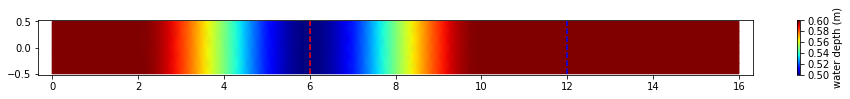

In [6]:
# Initalisaing Telemac file reader
res = TelemacFile(file_name)

# We want to compute the wet area at the first time frame
timeframe = 0

# Getting the water depth at the first time frame to plot it
water_depth = res.get_data_value('WATER DEPTH', timeframe)

# Plot the water depth at the first time frame and the lines on which we compute the wet area
fig, ax = plt.subplots(1, 1, figsize=(16, 1))

# Plotting the water depth
plot2d_scalar_map(fig, ax, res.tri, water_depth, data_name='water depth (m)')

# Plotting the two polylines
ax.plot(poly_points_bump[:,0],poly_points_bump[:,1],'r--')
ax.plot(poly_points_channel[:,0],poly_points_channel[:,1], 'b--')

plt.show()

Now let compute the wet area for our two polyline.

In [7]:
# Getting values
poly_coord_bump, abs_curv, values_polylines_bump = \
           res.get_timeseries_on_polyline('WATER DEPTH', 
                                          poly_points_channel, 
                                          poly_number)
poly_coord_channel, abs_curv, values_polylines_channel = \
           res.get_timeseries_on_polyline('WATER DEPTH', 
                                          poly_points_channel, 
                                          poly_number)

# Compute the wet area
area_bump = wet_area_2d(poly_coord_bump, values_polylines_bump)
area_channel = wet_area_2d(poly_coord_channel, values_polylines_channel)

# Print the wet area results
print("wet area over bump: ", area_bump[timeframe])
print("wet area over channel: ", area_channel[timeframe])

del res

wet area over bump:  0.50008979275
wet area over channel:  0.600000023842


## Exo 2: How to compute the flow rate through a polygonal chain

Compute the liquid discharge at the outlet of the Confluence test case and in the two tributaries.

In [14]:
from data_manip.computation.polyline_integrals import flux_2d
from os import chdir, environ, path
from data_manip.extraction.telemac_file import TelemacFile
import numpy as np
import matplotlib.pyplot as plt
from postel.plot2d import plot2d_scalar_map

# File we are going to use
file_name = path.join(environ['HOMETEL'], 
                          'examples', 
                          'telemac2d', 
                          'confluence',
                          'f2d_confluence.slf')

# Coordinates of the lines in which we want to compute the fluxes
line1 = np.array([[-10., 0.0], [-10., 0.8]])
line2 = np.array([[-7.5871568214477882, 2.7718446471440905], 
                  [-7.1535131343706952, 3.0167019187627968]])
line3 = np.array([[-1.0, 0.0], [-1.0, 0.8]])

# Discretization of the lines, number of points
line1_num = [20]
line2_num = [20]
line3_num = [20]

First same as before we display for the record 1 and the polylines.

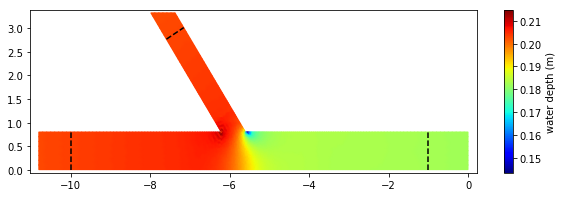

In [15]:
# Initalisaing Telemac file reader
res = TelemacFile(file_name)

# We want to compute the wet area at the second time frame (which is the last one)
timeframe = 1

# Getting array of time values from file 
times = res.times

# Getting the water depth at the last time frame to plot it
data = res.get_data_value('WATER DEPTH', timeframe)

# Plotting scalar map with the section in which the fluxes are computes
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

plot2d_scalar_map(fig, ax, res.tri, data, data_name='water depth (m)')

ax.plot(line1[:,0], line1[:,1],'k--')
ax.plot(line2[:,0], line2[:,1], 'k--')
ax.plot(line3[:,0], line3[:,1], 'k--')
    
# Showing the plot
plt.show()

Now we will need to extract the water depth, velocity u and v over our lines and compute the flux for each line.

In [16]:
# Extract the water depth and velocity values through the lines
def compute_flux(res, name, line, line_num):
    """
    Compute flux over a line
    
    @param res (TelemacFile) File from which to extract data
    @param name (str) Name of the line
    @param line (np.array) coordinates of the polyline
    """
    
    l_discrete, l_abs_curv, l_water_depth = \
            res.get_timeseries_on_polyline('WATER DEPTH', line, line_num)
        
    _, _, l_vel_u = res.get_timeseries_on_polyline('VELOCITY U', line, line_num)
    _, _, l_vel_v = res.get_timeseries_on_polyline('VELOCITY V', line, line_num)

    # Compute the fluxes for each line
    flux_x = np.multiply(l_vel_u, l_water_depth)
    flux_y = np.multiply(l_vel_v, l_water_depth)


    flow_rate = flux_2d(l_discrete, flux_x, flux_y)

    # Print the value of the fluxes
    print("{}: {} (m3/s)".format(name, flow_rate[timeframe]))

compute_flux(res, 'Main inlet', line1, line1_num)
compute_flux(res, 'Secondary inlet', line2, line2_num)
compute_flux(res, 'Outlet', line3, line3_num)

del res

Main inlet: 0.06825241996169397 (m3/s)
Secondary inlet: 0.03468950671541177 (m3/s)
Outlet: 0.10291670640980102 (m3/s)


/home/B61570/opentelemac/git/trunk/scripts/python3/data_manip/extraction/telemac_file.py:693: UserWarning: Warning: converting a masked element to nan.
  res[i] = data_interp(point[0], point[1])


## Exo 3: How to compute the solid discharge through a polygonal chain

Uses the result file of the SISYPHE test case bosse-t2d to compute the solid discharge over time at the outlet of the channel

In [18]:
from os import chdir, environ, path
from data_manip.extraction.telemac_file import TelemacFile
import numpy as np
from utils.geometry import get_norm2
from utils.exceptions import TelemacException
from data_manip.computation.polyline_integrals import flux_2d
import matplotlib.pyplot as plt
from postel.plot2d import plot2d_scalar_map
from postel.plot1d import plot1d

# File we are going to use
file_name = path.join(environ['HOMETEL'],
                      'notebooks',
                      'workshop',
                      'data',
                      'sis_bosse-t2d.slf')

# Coordinates of the lines in which we want to compute the fluxes
line = np.array([[9., -1], [9., 1]])

# Discretization of the lines, number of points
line_num = [10]

First we will display the bottom at record 0 with the polyline.

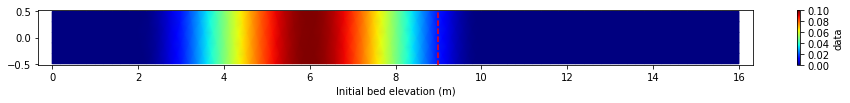

In [19]:
# Initalisaing Telemac file reader
res = TelemacFile(file_name)

# Getting array of time values from file 
times = res.times

# Extract the value of the bottom elevation at the initial time
data = res.get_data_value('BOTTOM', 0)

# Initialising matplotlib figure
fig, ax = plt.subplots(figsize=(16, 1))

# Plotting scalar map and the line
plot2d_scalar_map(fig, ax, res.tri, data, 'Initial bed elevation (m)')

ax.plot(line[:,0], line[:,1], 'r--')

plt.show()

Now we compute the solid discharge and plot its evolution over time.

/home/B61570/opentelemac/git/trunk/scripts/python3/data_manip/extraction/telemac_file.py:693: UserWarning: Warning: converting a masked element to nan.
  res[i] = data_interp(point[0], point[1])


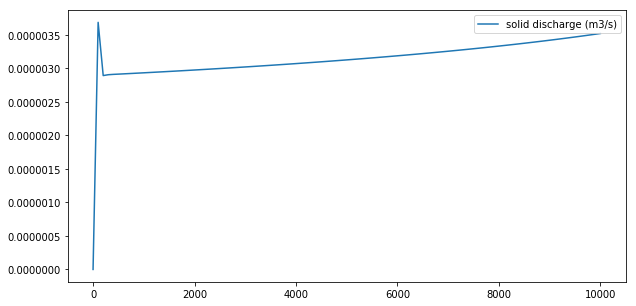

In [21]:
# Extract the solid discharge through the lines
line_discrete, line_abs_curv, qsb_x = res.get_timeseries_on_polyline('SOLID DISCH X', line, line_num)
_, _, qsb_y = res.get_timeseries_on_polyline('SOLID DISCH Y', line, line_num)

# Compute the fluxes
discharge = flux_2d(line_discrete, qsb_x, qsb_y)

# Plotting the solid discharge through the line over time
fig1, ax = plt.subplots(figsize=(10,5))

plot1d(ax, times, discharge, 'solid discharge (m3/s)')

# Displaying legend
ax.legend()

#Showing figure
plt.show()